# Analysis of termhood

This notebook contains most parts of the analysis on term, the importance of a term within a corpus of a certain domain.

In [3]:
import utils  # a python module in the same dir as the notebooks

In [4]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 5
C_VALUE_THRESHOLD = 2

In [6]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus/corpora
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:15<00:00, 101.50it/s]


## Question 1: What is the termhood of concepts incl. and excl. the counts of DC's?

In [8]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False, pos_filter='.*n')
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False, pos_filter='.*n')

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries and filtered out 4355 with the POS-tag filter: .*n
Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 88 with the POS-tag filter: .*n


In [9]:
from stats import conceptstats

In [10]:
term_freqs = conceptstats.count_concepts(corpus, discontinuous=False)
doc_freqs = conceptstats.count_concepts(corpus, discontinuous=False,
                                        doc_frequency=True)

In [11]:
c_values = conceptstats.calculate_c_values(cont_concepts, C_VALUE_THRESHOLD,
                                           term_freqs)
tf_idfs = conceptstats.calculate_tf_idf_values(cont_concepts, term_freqs,
                                               doc_freqs, len(corpus))


In [12]:
all_concepts = cont_concepts.union(disc_concepts)
term_freqs_incl_dc = conceptstats.count_concepts(corpus)
doc_freqs_incl_dc = conceptstats.count_concepts(corpus, doc_frequency=True)

In [13]:
c_values_incl_dc = conceptstats.calculate_c_values(all_concepts, C_VALUE_THRESHOLD,
                                                   term_freqs_incl_dc)
tf_idfs_incl_dc = conceptstats.calculate_tf_idf_values(all_concepts, term_freqs_incl_dc,
                                                       doc_freqs_incl_dc, len(corpus))

In [14]:
glossex_values = {concept: conceptstats.glossex(concept, model)
                  for concept in all_concepts}
pmi_nl_values = {concept: conceptstats.length_normalized_pmi(concept, model)
                 for concept in all_concepts}

Loading reference model for the first time.


In [15]:
import pandas as pd

data_dict = {'concept': [], 'freq': [], 'c-value': [], 'tf-idf': [],
             'freq_INCL' : [],'c-value_INCL': [], 'tf-idf_INCL': [],
             'glossex': [], 'pmi_nl': [], 'type': []}



for concept in all_concepts:
    
    if term_freqs[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    data_dict['freq'].append(term_freqs[concept])
    data_dict['freq_INCL'].append(term_freqs_incl_dc[concept])
    
    data_dict['c-value'].append(c_values[concept] if concept in c_values else None)
    data_dict['tf-idf'].append(tf_idfs[concept] if concept in tf_idfs else None)
    data_dict['c-value_INCL'].append(c_values_incl_dc[concept])
    data_dict['tf-idf_INCL'].append(tf_idfs_incl_dc[concept])
    data_dict['glossex'].append(glossex_values[concept])
    data_dict['pmi_nl'].append(pmi_nl_values[concept])
    
    
    if concept in cont_concepts:
        if concept in disc_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_CC'
    elif concept in disc_concepts:
        concept_type = 'only_DC'
    else:
        concept_type = 'neither'
    
    data_dict['type'].append(concept_type)


data = pd.DataFrame(data_dict)

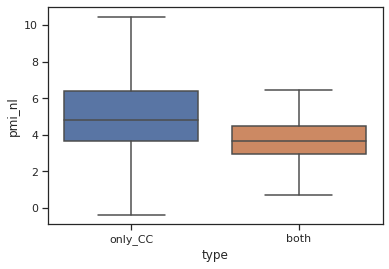

In [27]:
import seaborn as sns
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [19]:
data.sort_values('pmi_nl')

,concept,freq,c-value,tf-idf,freq_INCL,c-value_INCL,tf-idf_INCL,glossex,pmi_nl,type
314,"(human, gene)",5,5.000000,1599.000000,6,6.0,1599.0,4.773646,-0.519820,both
210,"(protein, factor)",5,4.000000,1599.000000,5,4.0,1599.0,4.431936,-0.354042,only_CC
449,"(human, cell)",11,9.666667,1954.333333,12,11.0,1918.8,3.951973,-0.261551,both
811,"(a, beta)",6,5.000000,4797.000000,6,5.0,4797.0,2.678277,0.382166,only_CC
393,"(protein, expression)",5,4.000000,1332.500000,5,4.0,1332.5,4.834855,0.559216,only_CC
...,...,...,...,...,...,...,...,...,...,...
809,"(leukotriene, b4)",9,8.000000,2398.500000,9,8.0,2398.5,3.542516,10.456876,only_CC
1041,"(mn, sod)",5,5.000000,3997.500000,5,5.0,3997.5,2.375838,10.572872,only_CC
963,"(cpg, island)",5,5.000000,1332.500000,5,5.0,1332.5,0.595315,10.620151,only_CC
530,"(mechanical, ventilation)",6,6.000000,4797.000000,6,6.0,4797.0,0.488819,10.771957,only_CC


In [20]:
import pingouin
pingouin.mwu(data[data['type'] == 'only_CC']['pmi_nl'],
             data[data['type'] == 'both']['pmi_nl'])

,U-val,tail,p-val,RBC,CLES
MWU,89046.5,two-sided,6.233977e-14,-0.406,0.703


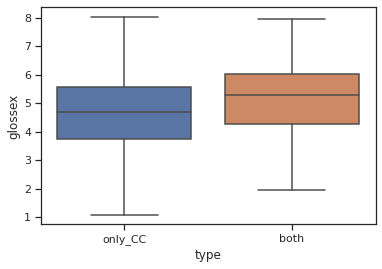

In [21]:
sns.boxplot(x='type', y='glossex', data=data, showfliers=False)

In [22]:
import pingouin
pingouin.mwu(data[data['type'] == 'only_CC']['glossex'],
             data[data['type'] == 'both']['glossex'])

,U-val,tail,p-val,RBC,CLES
MWU,49186.5,two-sided,0.000036,0.223,0.612


In [ ]:
%matplotlib notebook
import seaborn

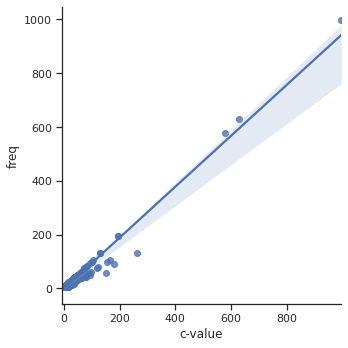

In [23]:
sns.lmplot(x='c-value', y='freq', data=data)

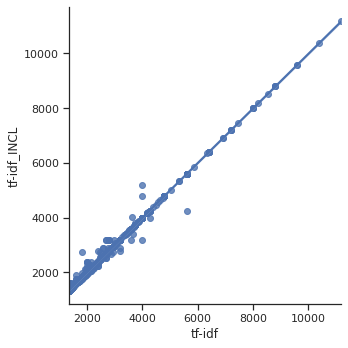

In [24]:
sns.lmplot(x='tf-idf', y='tf-idf_INCL', data=data)

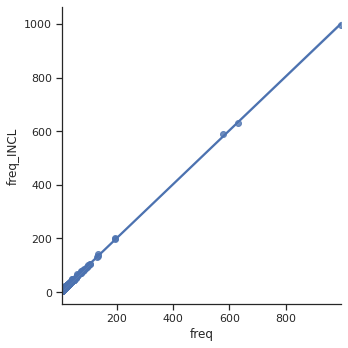

In [25]:
sns.boxplot(x='freq', y='freq_INCL', data=data)

In [ ]:
# we can perform t-tests etc.

Conclusion: Most DC's that we are interested in also occur as CC's, thus making them verifiable. The inclusion of these can enhance the term extraction recall and ranking.

In [33]:
pd.melt(data, id_vars=['concept'], value_vars=['freq', 'freq_INCL'])

,concept,variable,value
0,"(kinase, c)",freq,5
1,"(cell-free, system)",freq,6
2,"(plasma, cortisol)",freq,21
3,"(cyclosporin, a)",freq,72
4,"(ap-1, complex)",freq,11
...,...,...,...
2217,"(viral, protein)",freq_INCL,5
2218,"(nf-kappa, b, protein)",freq_INCL,6
2219,"(nitric, oxide)",freq_INCL,12
2220,"(monocyte-derived, macrophage)",freq_INCL,10


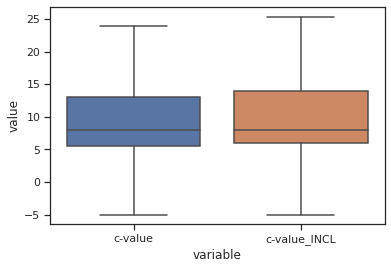

In [35]:
sns.boxplot(x='variable', y='value', data=pd.melt(data, id_vars=['concept'], value_vars=['c-value', 'c-value_INCL']), showfliers=False)

In [38]:
data.sort_values('c-value').head(50)

,concept,freq,c-value,tf-idf,freq_INCL,c-value_INCL,tf-idf_INCL,glossex,pmi_nl,type
419,"(western, blot)",5,-8.000000,1332.500000,5,-8.000000,1332.500000,1.369934,7.839528,only_CC
981,"(hiv-1, gene)",5,-5.000000,1599.000000,5,-5.000000,1599.000000,6.873920,1.495360,only_CC
1009,"(mobility, shift, assay)",8,-3.314013,1421.333333,8,-3.314013,1421.333333,3.878429,7.005318,only_CC
976,"(transient, expression)",5,-1.000000,1332.500000,5,-1.000000,1332.500000,4.439204,3.467991,only_CC
1100,"(transfection, assay)",5,-0.500000,1332.500000,5,-0.500000,1332.500000,5.771379,4.923738,only_CC
1049,"(htr, beta, 1, mrna)",7,0.000000,5596.500000,7,0.000000,5596.500000,4.455364,6.585919,only_CC
921,"(bat, box)",6,1.000000,4797.000000,6,1.000000,4797.000000,0.779367,7.779617,only_CC
634,"(monocytic, thp-1, cell)",5,1.584963,1599.000000,5,1.584963,1599.000000,5.772972,4.523254,only_CC
756,"(severe, combined, immunodeficiency)",5,1.584963,1998.750000,5,1.584963,1998.750000,3.935142,7.730824,only_CC
483,"(erythroid, gene)",5,2.000000,1998.750000,5,2.000000,1998.750000,6.213333,1.181847,only_CC


In [46]:
wb = set(('western', 'blot'))
for concept in cont_concepts:
    if wb.issubset(set(concept)):
        print(concept, term_freqs[concept])

('western', 'blot', 'analysis') 13
('western', 'blot') 5
('western', 'blot', 'assay') 1


True